## Лабораторная работа №8 по курсу "Нейроинформатика" на тему "Динамические сети"

*Целью работы*  является исследование свойств некоторых динамических нейронных сетей, алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.


### Вариант 10
Выполнил студент Шавандрин Фёдор  
Группа М8О-408Б-19

In [1]:
# импортируем библиотеки
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from collections import deque
import tqdm

Зададим управляющий сигнал $u(k)$ и выходной сигнал $y(k)$

In [2]:
def u(k):
    return np.sin(k**2 - 15 * k + 3) - np.sin(k)

In [3]:
N = 1000 # размер датасета

t = np.linspace(0, 5, N)

u_vals = u(t)

y = [0]
for i in range(len(t) - 1):
    y.append(y[-1] / (1 + y[-1]**2) + u_vals[i])

y = np.array(y)
assert u_vals.shape == y.shape
u_vals.shape

(1000,)

### Генерация датасета
Для генерация датасета для обучения разобьём имеющиеся точки на временные ряды.

In [4]:
def generate_dataset(x, y, delay=5):
    return [(
        np.array(x[i:i+delay], dtype=np.float32),
        np.array(y[i+delay], dtype=np.float32)
     ) for i in range(len(x) - delay)]

In [5]:
train_data = generate_dataset(u_vals, y)

Подготовим Data Loader из библиотеки Torch.

In [6]:
data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)

### Реализация сети NARX
Чтобы реализовать *NARX(Non-linear AutoRegressive network with eXogeneous inputs)*, необходимо реализовать вспомогательный слой *Time Delay Layer(TDL)*.

In [7]:
class TDL(nn.Module):
    def __init__(self, input_features, delay=1):
        super(TDL, self).__init__()
        self.input_features = input_features
        self.delay = delay
        self.line = deque()
        self.clear_deque()
    
    # функция очищения очереди (заполняем её нулями)
    def clear_deque(self):
        self.line.clear
        for i in range(self.delay):
            self.line.append(torch.zeros(self.input_features))
    
    def push_to_deque(self, input):
        self.line.appendleft(input)
    
    def forward(self, input=None):
        return self.line.pop()

Теперь реализуем NARX.

In [8]:
class NARX(nn.Module):
    def __init__(self, input_features, hidden_features, output_features, delay1, delay2):
        super(NARX, self).__init__()

        self.input_features = input_features
        self.hidden_features = hidden_features
        self.output_features = output_features

        self.line1 = TDL(input_features, delay1)
        self.line2 = TDL(output_features, delay2)

        self.w1 = torch.nn.Parameter(torch.randn(input_features, hidden_features))
        self.w2 = torch.nn.Parameter(torch.randn(hidden_features, output_features))
        self.w3 = torch.nn.Parameter(torch.randn(output_features, hidden_features))

        self.b1 = torch.nn.Parameter(torch.randn(hidden_features))
        self.b2 = torch.nn.Parameter(torch.randn(output_features))

    def clear(self):
        self.line1.clear_deque()
        self.line2.clear_deque()
    
    def forward(self, input):
        ans = torch.tanh(
            self.line1() @ self.w1 + self.line2() @ self.w3 + self.b1
        ) @ self.w2 + self.b2
        self.line1.push_to_deque(input.clone().detach())
        self.line2.push_to_deque(ans.clone().detach())
        return ans

### Обучение модели

В качестве алгоритма обучения буду использовать Adam, метрики - MSE.

In [15]:
model = NARX(5, 10, 1, 3, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [16]:
epochs = 30
loss = []
model.train()
for epoch in tqdm.tqdm(range(epochs)):
    epoch_loss = []
    for X_batch, y_batch in data_loader:
        y_pred = model(X_batch)
        cur_loss = criterion(y_batch, y_pred)
        epoch_loss.append(cur_loss.item())
        cur_loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    loss += [np.mean(epoch_loss)]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\Users\Adise\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:45<00:00,  1.52s/it]


### График лосса

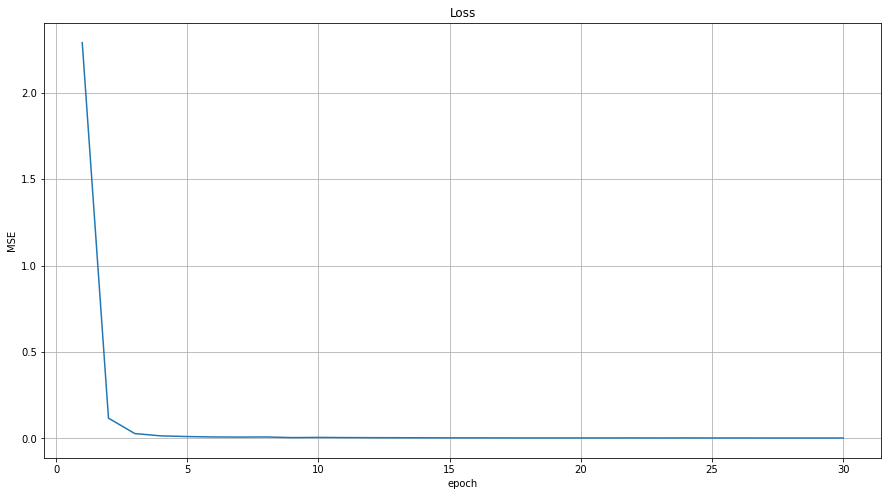

In [17]:
plt.figure(figsize=(15, 8))
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.plot(range(1, epochs+1), loss)
plt.title('Loss')
plt.grid()
plt.show()

In [18]:
print(f'MSE = {loss[-1]}')

MSE = 0.0028314534067064656


### Результат работы модели

In [19]:
model.eval()
model.clear()

predictions = []
for X_batch, _ in data_loader:
    predictions.append(model(X_batch).detach().numpy().item(-1))

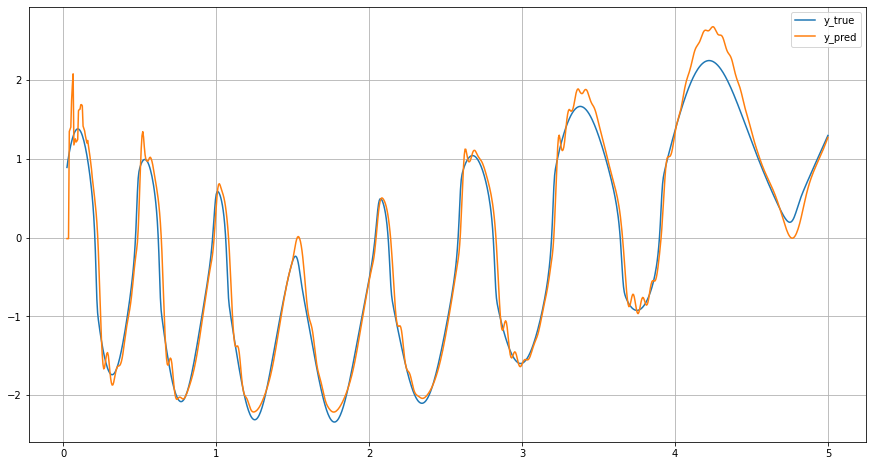

In [20]:
plt.figure(figsize=(15, 8))
plt.plot(t[5:], y[5:], label='y_true')
plt.plot(t[5:], predictions, label='y_pred')
plt.legend()
plt.grid()
plt.show()

Как видно из графика, модель достаточно точно предсказала сигнал, однако в точках минимума и максимума можно заметить "волны", которая модель выдаёт в качестве предсказанного ответа.

### Выводы

В ходе данной лабораторной работы познакомился с динамической сетью NARX, которую достаточно успешно применил для задачи предсказания сигнала. Получил маленький лосс, что ещё раз подтверждает, что сеть довольно хорошо справилась с заданием лабораторной работы.  

MSE = 0.003